# Notebook Setup

In [1]:
import pandas as pd
import seaborn as sb

from IPython.display import display

In [2]:
MEASURES_FILENAME = "./measures.csv"
CLOCK_ADJUST_RECTYPE = "CLOCK_ADJUSTED"
MEASURE_RECTYPE = "REGULAR"

COSC_LIMITS_SEC_DAY = (-4, 6)

GRAPH_STYLE = "whitegrid"

In [3]:
sb.set_theme("notebook", GRAPH_STYLE)
sb.set_style()

pd.options.display.max_rows = 6

# Read Data

In [4]:
# Read the csv
data = pd.read_csv(MEASURES_FILENAME)

# Put data back in chronological order
data = data.iloc[::-1].reset_index(drop=True)

In [5]:
# Rename columns to make coding comfy
data = data.rename(columns={
    "Type of record":"rectype",
    "Offset (seconds)":"offset"
})

In [6]:
data = data.astype({"rectype":"category"})

# Extract machine readable timestamps (utc)

In [7]:
data["timestamp"] = pd.to_datetime(data["Timestamp (Epoch Time)"], unit="ms")

# Create Unique Chain Numbers

In [8]:
data["seriesID"] = data.rectype.eq(CLOCK_ADJUST_RECTYPE).cumsum().shift(1, fill_value=0)

# Separate Measures

In [9]:
measures = (
    data
    .query("rectype == @MEASURE_RECTYPE")
    .copy()
    .drop(["rectype", "Series Accuracy (Seconds/day)"], axis="columns")
)
measures

,Timestamp (Epoch Time),Timestamp (Human Readable),offset,timestamp,seriesID
0,1643217195058,Wed Jan 26 12:13:15 EST 2022,0.0,2022-01-26 17:13:15.058,0
1,1643222760664,Wed Jan 26 13:46:00 EST 2022,0.0,2022-01-26 18:46:00.664,0
2,1643226456184,Wed Jan 26 14:47:36 EST 2022,-1.0,2022-01-26 19:47:36.184,0
...,...,...,...,...,...
95,1643714133212,Tue Feb 01 06:15:33 EST 2022,-7.0,2022-02-01 11:15:33.212,2
96,1643722758672,Tue Feb 01 08:39:18 EST 2022,-8.0,2022-02-01 13:39:18.672,2
97,1643725073727,Tue Feb 01 09:17:53 EST 2022,-8.0,2022-02-01 14:17:53.727,2


# Separate Chain Infos

In [10]:
seriesInfo = (
    data
    .query("rectype == @CLOCK_ADJUST_RECTYPE")
    .set_index("seriesID")
    .loc[:, ["timestamp", "Timestamp (Human Readable)", "Series Accuracy (Seconds/day)"]]
    .rename({
        "timestamp":"seriesEnd",
        "Timestamp (Human Readable)":"seriesEnd (Human Readable)",
        "Series Accuracy (Seconds/day)":"appDriftRate"
    }, axis="columns")
)

seriesInfo

,seriesEnd,seriesEnd (Human Readable),appDriftRate
seriesID,,,
0,2022-01-28 18:44:40.618,Fri Jan 28 13:44:40 EST 2022,-6.787305
1,2022-01-31 14:56:32.454,Mon Jan 31 09:56:32 EST 2022,-7.045547


# Relative Time Within Series

In [11]:
seriesStarts = measures.groupby("seriesID").timestamp.min()

measures["adjustmentAge"] = measures.timestamp - measures.seriesID.map(seriesStarts)
measures["adjustmentDays"] = measures.adjustmentAge.dt.total_seconds() / 3600 / 24

seriesInfo = seriesInfo.merge(seriesStarts.rename("seriesStart"), "outer", left_index=True, right_index=True)

# Spot Rates

In [12]:
measures["spotRate"] = measures.offset / measures.adjustmentDays

# Quick Look at the Data

In [13]:
measures

,Timestamp (Epoch Time),Timestamp (Human Readable),offset,timestamp,seriesID,adjustmentAge,adjustmentDays,spotRate
0,1643217195058,Wed Jan 26 12:13:15 EST 2022,0.0,2022-01-26 17:13:15.058,0,0 days 00:00:00,0.000000,NaN
1,1643222760664,Wed Jan 26 13:46:00 EST 2022,0.0,2022-01-26 18:46:00.664,0,0 days 01:32:45.606000,0.064417,0.000000
2,1643226456184,Wed Jan 26 14:47:36 EST 2022,-1.0,2022-01-26 19:47:36.184,0,0 days 02:34:21.126000,0.107189,-9.329319
...,...,...,...,...,...,...,...,...
95,1643714133212,Tue Feb 01 06:15:33 EST 2022,-7.0,2022-02-01 11:15:33.212,2,0 days 20:18:48.114000,0.846390,-8.270417
96,1643722758672,Tue Feb 01 08:39:18 EST 2022,-8.0,2022-02-01 13:39:18.672,2,0 days 22:42:33.574000,0.946222,-8.454676
97,1643725073727,Tue Feb 01 09:17:53 EST 2022,-8.0,2022-02-01 14:17:53.727,2,0 days 23:21:08.629000,0.973017,-8.221854


In [14]:
seriesInfo

,seriesEnd,seriesEnd (Human Readable),appDriftRate,seriesStart
seriesID,,,,
0,2022-01-28 18:44:40.618,Fri Jan 28 13:44:40 EST 2022,-6.787305,2022-01-26 17:13:15.058
1,2022-01-31 14:56:32.454,Mon Jan 31 09:56:32 EST 2022,-7.045547,2022-01-28 18:46:35.215
2,NaT,NaN,NaN,2022-01-31 14:56:45.098


# Plot Offsets

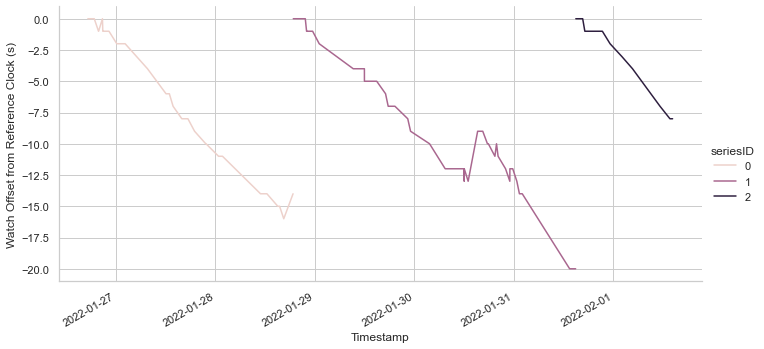

In [15]:
f = sb.relplot(data=measures, x="timestamp", y="offset", hue="seriesID", kind="line", aspect=2)
f.set_axis_labels("Timestamp", "Watch Offset from Reference Clock (s)")
f.figure.autofmt_xdate()

# Plot Superposed Adjustment Cycles

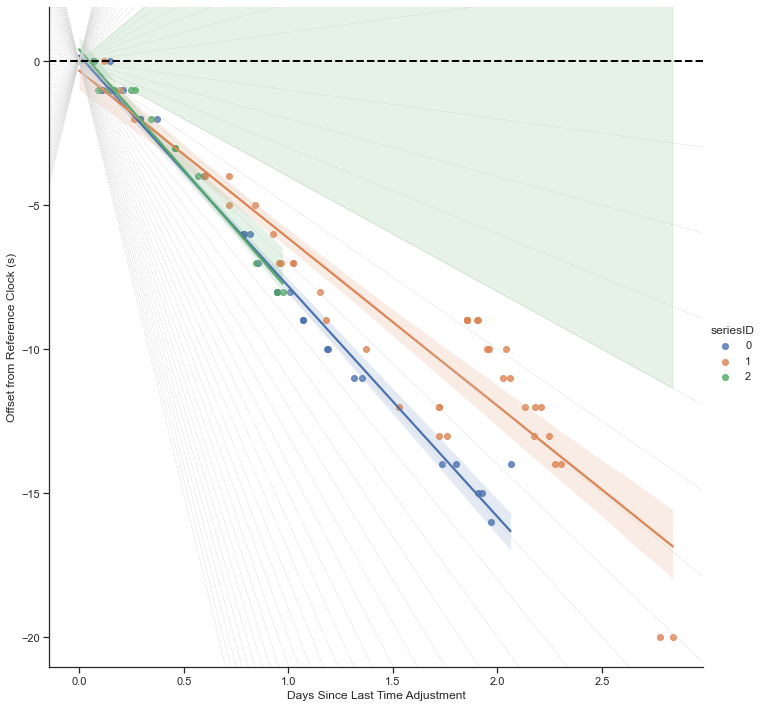

In [16]:
sb.set_style("ticks")
f = sb.lmplot(data=measures, x="adjustmentDays", y="offset", hue="seriesID", height=10)
ylim = f.ax.get_ylim()

maxDays = measures.adjustmentDays.max()
minOffset = measures.offset.min()

limitsX = [0, maxDays]
limitYMin = [0, maxDays * COSC_LIMITS_SEC_DAY[0]]
limitYMax = [0, maxDays * COSC_LIMITS_SEC_DAY[1]]

f.ax.fill_between(limitsX, limitYMin, limitYMax, color="green", alpha=0.1, zorder=0)

for i in range(-30,31):
    f.ax.axline((0,0), (1/100, i/100), c="lightgrey", lw=0.5, ls="--")

f.ax.axhline(0, c="black", lw=2, ls="--")

f.ax.set_ylim(ylim)
f.set_axis_labels("Days Since Last Time Adjustment", "Offset from Reference Clock (s)")

# Get Drift Rates

In [17]:
from scipy.stats import linregress

def chainStats(df):
    
    linreg = linregress(df.adjustmentDays, df.offset)
    
    initalSampleCount = df.index.size
    
    df = df.query("abs(offset) > 0")
    
    return pd.Series(
        {
            "initialSamples":initalSampleCount,
            "nonZeroSamples":df.index.size,
            "finalOffset":df.offset.iat[-1],
            "observationDays":df.adjustmentDays.iat[-1],
            "median":df.spotRate.median(),
            "mean":df.spotRate.mean(),
            "stddev":df.spotRate.std(),
            "final":df.spotRate.iat[-1],
            "avgFinal3":df.spotRate.tail(3).mean(),
            "slope":linreg.slope, "R":linreg.rvalue,
            
        })

stats = measures.groupby("seriesID").apply(chainStats)
stats = stats.join(seriesInfo.appDriftRate).join(seriesInfo.seriesStart.dt.date)
(
    stats
    .style
    .format("{:.0f}", pd.IndexSlice[:, :"observationDays"])
    .format("{:.2f}", pd.IndexSlice[:, "observationDays":"appDriftRate"], na_rep="...")
)

,initialSamples,nonZeroSamples,finalOffset,observationDays,median,mean,stddev,final,avgFinal3,slope,R,appDriftRate,seriesStart
seriesID,,,,,,,,,,,,,
0,35,32,-14,2.06,-7.82,-7.66,1.04,-6.79,-7.56,-8.01,-0.99,-6.79,2022-01-26
1,45,42,-20,2.84,-6.31,-6.27,1.03,-7.05,-6.78,-5.82,-0.95,-7.05,2022-01-28
2,16,12,-8,0.97,-6.77,-6.92,1.99,-8.22,-8.32,-8.35,-0.99,...,2022-01-31
